In [4]:
from datasets import load_dataset

squad_dataset = load_dataset("sentence-transformers/squad", split="train")
squad_dataset

Dataset({
    features: ['question', 'answer'],
    num_rows: 87599
})

In [7]:
squad_dataset.set_format("pandas")
df = squad_dataset[:]
df.head()

,question,answer
0,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha..."
1,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha..."
2,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha..."
3,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha..."
4,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha..."


In [9]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['question', 'answer'],
    num_rows: 87599
})

In [ ]:
df.head()

# Osadzenia zapytań i dokumentów

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [56]:
import torch

from sentence_transformers import SentenceTransformer

model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
embedder = SentenceTransformer(model_name, device=device)

# Corpus with example sentences
corpus = df["answer"].tolist()
# Query sentences:
queries = df["question"].tolist()
corpus_set = list(set(corpus))
corpus_to_set_index = {ans: i for i, ans in enumerate(corpus_set)}


In [51]:
corpus_set.__len__(), queries.__len__() 


(18891, 87599)

In [52]:

# Use "convert_to_tensor=True" to keep the tensors on GPU (if available)
corpus_embeddings = embedder.encode(corpus_set, convert_to_tensor=True, show_progress_bar=True, batch_size=64)

Batches: 100%|██████████| 296/296 [03:11<00:00,  1.54it/s]


In [53]:
query_embeddings = embedder.encode(queries, convert_to_tensor=True, show_progress_bar=True, batch_size=64)


Batches: 100%|██████████| 1369/1369 [01:19<00:00, 17.21it/s]


In [57]:
# Metryki
top_k = 5
correct_top1, correct_top5 = 0, 0
total_reciprocal_rank = 0
total_average_precision = 0

# Iteracja przez zapytania
for i in range(len(queries)):
    # Oblicz podobieństwo kosinusowe
    similarity_scores = torch.nn.functional.cosine_similarity(query_embeddings[i].unsqueeze(0), corpus_embeddings)
    scores, indices = torch.topk(similarity_scores, k=top_k)

    # Prawidłowy indeks z corpus_set
    ground_truth_idx = corpus_to_set_index[corpus[i]]  

    # Sprawdzenie poprawności
    if ground_truth_idx == indices[0]:  # Top-1
        correct_top1 += 1
    if ground_truth_idx in indices:  # Top-5
        correct_top5 += 1

    # Obliczanie MRR
    for rank, idx in enumerate(indices):
        if ground_truth_idx == idx:
            total_reciprocal_rank += 1.0 / (rank + 1)
            break

    # Obliczanie MAP
    relevant = 0
    precision_at_k = 0
    for rank, idx in enumerate(indices):
        if ground_truth_idx == idx:
            relevant += 1
            precision_at_k += relevant / (rank + 1)
    if relevant > 0:
        average_precision = precision_at_k / relevant
        total_average_precision += average_precision

# Obliczenie metryk
num_queries = len(queries)
top1_accuracy = correct_top1 / num_queries
top5_accuracy = correct_top5 / num_queries
mrr = total_reciprocal_rank / num_queries
map_score = total_average_precision / num_queries

print(f"Top-1 Accuracy: {top1_accuracy:.4f}")
print(f"Top-5 Accuracy: {top5_accuracy:.4f}")
print(f"MRR: {mrr:.4f}")
print(f"MAP: {map_score:.4f}")


Top-1 Accuracy: 0.6452
Top-5 Accuracy: 0.8739
MRR: 0.7365
MAP: 0.7365


# Indeksowanie z FAISS

In [78]:
import faiss
import numpy as np

# Konwersja osadzeń na NumPy dla FAISS
corpus_embeddings_np = corpus_embeddings.cpu().numpy()
query_embeddings_np = query_embeddings.cpu().numpy()

faiss.normalize_L2(query_embeddings_np)  # Normalizacja zapytań
faiss.normalize_L2(corpus_embeddings_np)  # Normalizacja korpusu

# Utworzenie indeksu FAISS
dimension = corpus_embeddings_np.shape[1]  # Wymiar osadzeń
index = faiss.IndexFlatL2(dimension)  # Indeks z metryką L2 (euklidesową)
index.add(corpus_embeddings_np)  # Dodanie osadzeń do indeksu

# Wyszukiwanie najbliższych sąsiadów
top_k = 5
_, indices = index.search(query_embeddings_np, top_k)

# Metryki oceny
correct_top1, correct_top5 = 0, 0
total_reciprocal_rank = 0
total_average_precision = 0

# Ewaluacja dla każdego zapytania
for i in range(len(queries)):
    top_indices = indices[i]  # Indeksy top-k z FAISS
    ground_truth_idx = corpus_to_set_index[corpus[i]]  # Indeks ground truth w corpus_set

    # Top-1 i Top-5 Accuracy
    if ground_truth_idx == top_indices[0]:  # Top-1
        correct_top1 += 1
    if ground_truth_idx in top_indices:  # Top-5
        correct_top5 += 1

    # MRR (Mean Reciprocal Rank)
    for rank, idx in enumerate(top_indices):
        if ground_truth_idx == idx:
            total_reciprocal_rank += 1.0 / (rank + 1)
            break

    # MAP (Mean Average Precision)
    relevant = 0
    precision_at_k = 0
    for rank, idx in enumerate(top_indices):
        if ground_truth_idx == idx:
            relevant += 1
            precision_at_k += relevant / (rank + 1)
    if relevant > 0:
        average_precision = precision_at_k / relevant
        total_average_precision += average_precision

# Obliczenie metryk
num_queries = len(queries)
top1_accuracy = correct_top1 / num_queries
top5_accuracy = correct_top5 / num_queries
mrr = total_reciprocal_rank / num_queries
map_score = total_average_precision / num_queries

# Wyświetlenie wyników
print(f"Top-1 Accuracy: {top1_accuracy:.4f}")
print(f"Top-5 Accuracy: {top5_accuracy:.4f}")
print(f"MRR: {mrr:.4f}")
print(f"MAP: {map_score:.4f}")


Top-1 Accuracy: 0.6452
Top-5 Accuracy: 0.8739
MRR: 0.7365
MAP: 0.7365


# Metryki

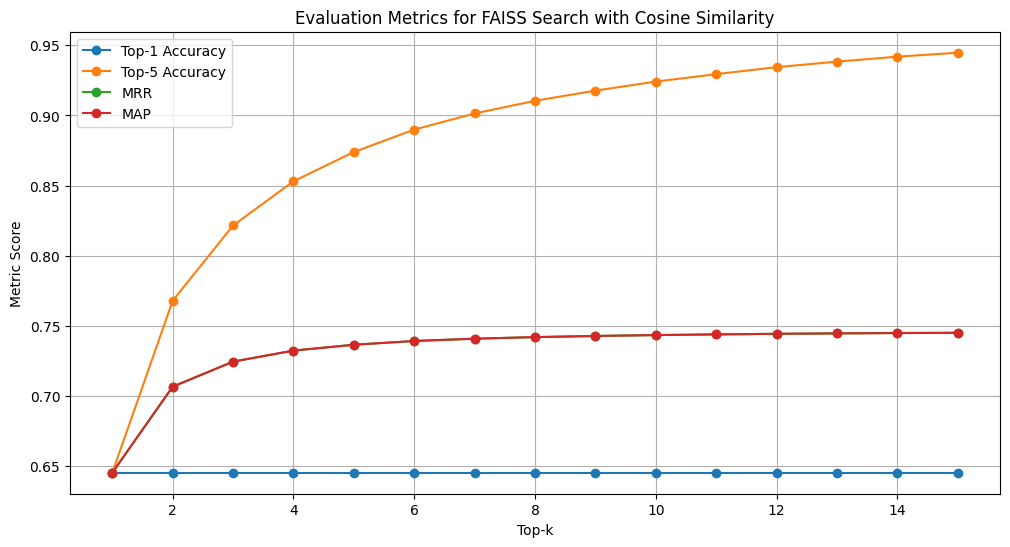

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import faiss

ground_truth = corpus

# Funkcja pomocnicza do obliczania MRR
def mean_reciprocal_rank(ground_truth, indices, corpus_to_set_index, corpus_set):
    mrr = 0
    for i, gt in enumerate(ground_truth):
        ground_truth_idx = corpus_to_set_index[gt]  # Indeks w corpus_set
        for rank, idx in enumerate(indices[i]):
            if idx == ground_truth_idx:
                mrr += 1 / (rank + 1)  # Odwrotność rangi
                break
    return mrr / len(ground_truth)

# Funkcja pomocnicza do obliczania MAP
def mean_average_precision(ground_truth, indices, corpus_to_set_index, corpus_set):
    map_score = 0
    for i, gt in enumerate(ground_truth):
        ground_truth_idx = corpus_to_set_index[gt]  # Indeks w corpus_set
        relevant = 0
        precision_sum = 0
        for rank, idx in enumerate(indices[i]):
            if idx == ground_truth_idx:
                relevant += 1
                precision_sum += relevant / (rank + 1)
        map_score += precision_sum / relevant if relevant > 0 else 0
    return map_score / len(ground_truth)

# Normalizacja osadzeń
query_embeddings_np = query_embeddings.cpu().numpy()
corpus_embeddings_np = corpus_embeddings.cpu().numpy()

faiss.normalize_L2(query_embeddings_np)  # Normalizacja zapytań
faiss.normalize_L2(corpus_embeddings_np)  # Normalizacja korpusu

# Utworzenie indeksu FAISS z Inner Product (dla cosine similarity)
dimension = corpus_embeddings_np.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(corpus_embeddings_np)  # Dodanie znormalizowanych osadzeń do indeksu

# Przygotowanie zmiennych
corpus_set = list(set(corpus))  # Usunięcie duplikatów z korpusu
corpus_to_set_index = {ans: i for i, ans in enumerate(corpus_set)}  # Mapowanie odpowiedzi na indeksy

# Metryki
top_k_values = list(range(1, 16))  # Top-k od 1 do 15
top1_accuracies = []
top5_accuracies = []
mrr_values = []
map_values = []

# Pętla po wartościach top_k
for top_k in top_k_values:
    correct_top1, correct_top5 = 0, 0
    _, indices = index.search(query_embeddings_np, top_k)  # FAISS wyszukiwanie najbliższych sąsiadów
    
    for i in range(len(queries)):
        ground_truth_idx = corpus_to_set_index[ground_truth[i]]  # Indeks prawidłowej odpowiedzi
        top_indices = indices[i]  # Top-k indeksy dla zapytania
        
        # Top-1 i Top-5 Accuracy
        if top_indices[0] == ground_truth_idx:
            correct_top1 += 1
        if ground_truth_idx in top_indices:
            correct_top5 += 1

    # Obliczenie metryk
    top1_accuracy_faiss = correct_top1 / len(queries)
    top5_accuracy_faiss = correct_top5 / len(queries)
    mrr_faiss = mean_reciprocal_rank(ground_truth, indices, corpus_to_set_index, corpus_set)
    map_faiss = mean_average_precision(ground_truth, indices, corpus_to_set_index, corpus_set)

    # Dodanie wyników do list
    top1_accuracies.append(top1_accuracy_faiss)
    top5_accuracies.append(top5_accuracy_faiss)
    mrr_values.append(mrr_faiss)
    map_values.append(map_faiss)


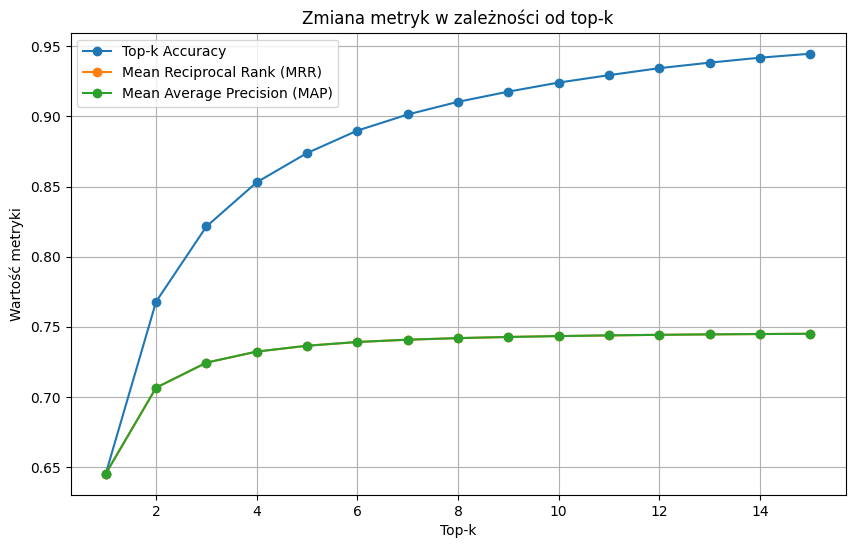

In [66]:
# Wykres
plt.figure(figsize=(10, 6))

plt.plot(top_k_values, top5_accuracies, label="Top-k Accuracy", marker='o')
plt.plot(top_k_values, mrr_values, label="Mean Reciprocal Rank (MRR)", marker='o')
plt.plot(top_k_values, map_values, label="Mean Average Precision (MAP)", marker='o')

plt.xlabel("Top-k")
plt.ylabel("Wartość metryki")
plt.title("Zmiana metryk w zależności od top-k")
plt.legend()
plt.grid(True)
plt.show()

# Wnioski:
* Wyniki z FAISS i bez FAISS wyszły takie same
* Kiedy nie znormalizujemy embeddingów przy faiss, to dostajemy ciut gorsze wyniki
* FAISS jest o wiele szybsze (10s) od wyszukiwania iloczynem skalarnym (7 minut)

# Przykłady 

In [82]:
import random
top_k = 5

random.seed(42)
for query in random.choices(queries, k=5):
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    similarity_scores = embedder.similarity(query_embedding, corpus_embeddings)[0]
    scores, indices = torch.topk(similarity_scores, k=top_k)

    print("\nQuery:", query)
    print("Top 5 most similar sentences in corpus:")

    for score, idx in zip(scores, indices):
        # Przypisanie poprawnego indeksu w corpus_set
        correct_index = idx.item()  # Zamiana tensora na wartość indeksu
        print(f"{corpus_set[correct_index]} (Index: {correct_index}, Score: {score:.4f})")


Query: Where is the Four Seasons Town Center located?
Top 5 most similar sentences in corpus:
North Carolina has a variety of shopping choices. SouthPark Mall in Charlotte is currently the largest in the Carolinas, with almost 2.0 million square feet. Other major malls in Charlotte include Northlake Mall and Carolina Place Mall in nearby suburb Pineville. Other major malls throughout the state include Hanes Mall in Winston-Salem; Crabtree Valley Mall, North Hills Mall, and Triangle Town Center in Raleigh; Friendly Center and Four Seasons Town Centre in Greensboro; Oak Hollow Mall in High Point; Concord Mills in Concord; Valley Hills Mall in Hickory; and The Streets at Southpoint and Northgate Mall in Durham and Independence Mall in Wilmington, NC, and Tanger Outlets in Charlotte, Nags Head, Blowing Rock, and Mebane, NC. (Index: 14951, Score: 19.1315)
As one of the oldest parts of town, Central Tucson is anchored by the Broadway Village shopping center designed by local architect Josia